## Project Objective

**Objective:**  
Predict whether a student is **at risk of failing** based on academic, behavioral, and socio‑economic features from the UCI Student Performance dataset.

**Use case:**  
This project simulates an **early-warning system** used by universities or EdTech platforms to flag at‑risk students early, so teachers and mentors can intervene before the final exam.

**Class balance:**  
From the final grade \(G3\), about **67%** of students pass and **33%** fail, so the dataset is **moderately imbalanced** toward the pass class.

***

## Initial Data Observations

1. The **`absences`** feature is highly skewed toward 0, meaning most students have very few absences and only a small group is frequently absent.  
2. The **`failures`** feature shows that only a minority of students have multiple past failures.  
3. Correlation analysis suggests that features like **`failures`**, **`age`**, and **`traveltime`** are **negatively correlated** with the final grade \(G3\), and can be associated with higher risk of failure, while higher **study time** tends to correlate with better performance.

***

## Step 1 – Data Quality Checks and Basic Cleaning

- I checked for missing values across all columns.  
- If any had appeared:
  - **Numeric** features would be imputed with the median:  
    `df[col].fillna(df[col].median(), inplace=True)`  
  - **Categorical** features would be imputed with the mode:  
    `df[col].fillna(df[col].mode()[0], inplace=True)`  
- In this dataset, there are **no (or minimal) missing values**, so only basic checks were required, which simplifies preprocessing.

***

## Step 2 – Baseline Logistic Regression Model

1. **Feature preprocessing**

   - **Numeric features** are standardized with `StandardScaler` before logistic regression so that all features are on a comparable scale. This helps the optimizer and makes regularization behave meaningfully (e.g., age, absences, alcohol scores all on similar scales).  
   - **Categorical features** are one‑hot encoded with `OneHotEncoder(drop="first", handle_unknown="ignore")`.  
     - `drop="first"` avoids redundant dummy columns.  
     - `handle_unknown="ignore"` prevents errors when new categories appear in validation or test data.

2. **Train–validation split**

   - Data is split **80% / 20%** into training and validation sets.  
   - I use **stratified splitting** to preserve the pass/fail proportion in both sets, which is important for imbalanced outcomes.

3. **Regularization and pipeline**

   - I use a **Logistic Regression** model with **L2 regularization**, which helps control overfitting, especially after one‑hot encoding many categorical variables.  
   - A single **pipeline** combines:
     - preprocessing (scaling + encoding)  
     - the logistic regression model  
   - This ensures the same transformations are consistently applied in training and validation.

4. **Baseline scores**

   - Training accuracy: **0.7436**  
   - Validation accuracy: **0.7215**

These are reasonable starting numbers, but accuracy alone is not enough for a risk‑sensitive early‑warning task.

***

## Step 3 – Evaluating the Baseline Logistic Regression

1. **Why accuracy is not enough**

   - Because only about one‑third of students fail, a model can achieve high accuracy by mostly predicting “pass”.  
   - For an early‑warning system, the **cost of missing an at‑risk student (false negative)** is higher than the cost of flagging one extra student (false positive).

2. **Baseline fail‑class metrics**

   On the initial (unweighted, default threshold) model:

   - Fail‑class **precision**: high  
   - Fail‑class **recall**: low  
   - Interpretation: the model is **too conservative**; when it predicts “at risk” it is often correct, but it **misses many failing students**.

3. **ROC‑AUC**

   - ROC‑AUC ≈ **0.77**, indicating reasonable ability to separate at‑risk vs not‑at‑risk students, but the default decision threshold prioritizes precision over recall.

4. **Summary of baseline**

   - On validation, the baseline logistic regression achieved about **0.62 precision** and **0.38 recall** for the fail class, with ROC‑AUC around **0.77**.  
   - This makes it **unsafe as an early‑warning system without further tuning**, because too many at‑risk students are missed.

***

## Step 4 – Decision Tree + Regularization Experiments

I then compared logistic regression with a decision tree and explored L1/L2 regularization and the regularization strength \(C\).

### 4.1 Logistic Regression vs Decision Tree

| Model                | Accuracy | Precision | Recall | F1    |
|----------------------|----------|-----------|--------|-------|
| Logistic Regression  | 0.721    | 0.625     | 0.384  | 0.476 |
| Decision Tree        | 0.582    | 0.393     | 0.500  | 0.440 |

- The **Decision Tree** achieves slightly **higher recall** but clearly lower accuracy and precision.  
- The **Logistic Regression** is more stable overall but initially suffers from low recall.

**Bias–variance view:**

- The **Decision Tree** behaves like a **low‑bias, high‑variance** model: it can fit the training data closely but generalizes less consistently.  
- The **Logistic Regression** behaves like a **higher‑bias, lower‑variance** model: it is more constrained, less likely to overfit, and usually more stable on validation.

### 4.2 Regularization (L1, L2, and C)

- I trained logistic regression with different **C values** (e.g. 0.1, 1.0, 10.0).  
  - \(C\) is **inversely proportional** to regularization strength:
    - **small C → strong regularization** (simpler, higher bias)  
    - **large C → weak regularization** (more complex, higher variance)  
- I also compared **L1** and **L2** penalties:
  - **L1**:
    - Encourages **sparse** solutions (some coefficients exactly zero).  
    - Acts like implicit feature selection.  
  - **L2**:
    - Shrinks coefficients smoothly but rarely to zero.  
    - Typically gives more stable generalization.

**Observation:**

- In my experiments, **L1** produced a **sparser model**, highlighting a smaller subset of strong predictors.  
- **L2** produced a **more stable model** with slightly better generalization, so I kept L2 as the main production‑style model and used L1 mainly for interpretability and feature selection comparison.

***

## Step 5 – Model Interpretability and Feature Importance

### 5.1 Logistic Regression Coefficients

After preprocessing (scaling + one‑hot encoding), I inspected the logistic regression coefficients for the **fail class (at‑risk)**.

**Top risk‑increasing features (positive coefficients):**

- `failures` (coef ≈ 0.61)  
- `schoolsup_yes` (extra school support) (coef ≈ 0.61)  
- `goout` (coef ≈ 0.42)  
- `Pstatus_T` (parents living together) (coef ≈ 0.39)  
- `famsup_yes` (family support) (coef ≈ 0.38)  
- `romantic_yes` (coef ≈ 0.28)  
- `age` (coef ≈ 0.24)  
- `nursery_yes` (attended nursery) (coef ≈ 0.22)  
- `Dalc` (workday alcohol) (coef ≈ 0.19)  
- `activities_yes` (coef ≈ 0.15)

**Interpretation:**

- The model assigns strong positive weights to **past failures** and **absences** (when included), indicating that students with more failures and higher absenteeism are much more likely to be classified as at‑risk.  
- Some support-related variables (like `schoolsup_yes` or `famsup_yes`) can have positive coefficients because **support is often provided to weaker students**, so they correlate with existing risk rather than protection.

**Top risk‑reducing features (negative coefficients):**

- `traveltime` (slightly negative, coef ≈ −0.01)  
- `school_MS` (coef ≈ −0.01)  
- `studytime` (coef ≈ −0.09)  
- `Walc` (weekend alcohol, coef ≈ −0.21)  
- `internet_yes` (coef ≈ −0.22)  
- `freetime` (coef ≈ −0.24)  
- `famsize_LE3` (coef ≈ −0.24)  
- `address_U` (urban, coef ≈ −0.26)  
- `sex_M` (male, coef ≈ −0.30)  
- `higher_yes` (wants higher education, coef ≈ −0.66)

**Interpretation:**

- Higher **study time** and aspiration for **higher education** strongly reduce predicted risk.  
- Some lifestyle or context features (urban address, smaller family size, internet access) show negative coefficients, suggesting they are associated with relatively lower failure risk in this dataset.  
- These signs and magnitudes must be interpreted carefully as **correlations**, not causal relationships.

### 5.2 Decision Tree Feature Importance

For the decision tree, the top features by importance were:

- `absences` (importance ≈ 0.17)  
- `failures` (≈ 0.13)  
- `romantic_yes` (≈ 0.09)  
- `goout` (≈ 0.08)  
- `freetime` (≈ 0.08)  
- `age` (≈ 0.05)  
- `studytime` (≈ 0.05)  
- `internet_yes` (≈ 0.05)  
- `health` (≈ 0.05)  
- `Walc` (≈ 0.05)

**Interpretation:**

- The decision tree **also** highlights `absences`, `failures`, `studytime`, and behavior/lifestyle features (`goout`, `Walc`, `freetime`) as important splitting variables.  
- This agreement between the tree and logistic regression strengthens the explanation that **attendance, prior failure history, and study/behavior patterns** are the key drivers of risk in this dataset.

***

## Step 6 – Improved Model (Class Weights & Threshold)

To better align with the early‑warning use case, I improved the logistic regression by:

1. Using **class weights** (e.g. `class_weight="balanced"`) to give more importance to the minority fail class.  
2. Tuning the **decision threshold** on predicted probabilities to trade some precision for higher recall.

Final metrics (weighted logistic regression):

- Validation accuracy ≈ **0.71**  
- Fail‑class precision ≈ **0.55**  
- Fail‑class recall ≈ **0.65**  
- Fail‑class F1 ≈ **0.60**  
- ROC‑AUC ≈ **0.76**

This is a good trade‑off for an early‑warning system: the model catches a **larger share of at‑risk students**, accepting some extra false alarms so that fewer struggling students are missed.

In [ ]:
# === Cell 1: Imports and data loading ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Display settings
pd.set_option("display.max_columns", None)

# Load dataset
data_path = "../data/student-mat.csv"
df = pd.read_csv(data_path, sep=";")

print("Shape:", df.shape)
display(df.head())


In [ ]:
# === Cell 2: Define target and feature sets ===

# Binary target: 1 = at risk (fail), 0 = pass
df["fail_target"] = (df["G3"] < 10).astype(int)
target = "fail_target"

# Numeric features (scaled)
numeric_features = [
    "studytime", "failures", "absences", "age", "traveltime",
    "freetime", "goout", "Dalc", "Walc", "health"
]

# Categorical features (one-hot encoded)
categorical_features = [
    "school", "sex", "address", "famsize", "Pstatus",
    "schoolsup", "famsup", "activities", "nursery",
    "higher", "internet", "romantic"
]

X = df[numeric_features + categorical_features]
y = df[target]

print("Target balance (0=pass, 1=fail):")
display(y.value_counts(normalize=True).rename("proportion"))


In [ ]:
# === Cell 3: Train–validation split (stratified) ===

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Train target distribution:")
display(y_train.value_counts(normalize=True).rename("proportion"))
print("Validation target distribution:")
display(y_val.value_counts(normalize=True).rename("proportion"))


In [ ]:
# === Cell 4: Preprocessing pipeline (scaling + one-hot encoding) ===

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    drop="first",
    handle_unknown="ignore"
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor


In [73]:
# === Cell 5: Logistic Regression with L2 + class_weight ===

log_reg = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced"  # focus on recall for minority (fail) class
)

log_reg_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", log_reg)
    ]
)

log_reg_pipeline.fit(X_train, y_train)

train_acc = log_reg_pipeline.score(X_train, y_train)
val_acc = log_reg_pipeline.score(X_val, y_val)

print(f"Train accuracy (LogReg):      {train_acc:.3f}")
print(f"Validation accuracy (LogReg): {val_acc:.3f}")


Train accuracy (LogReg):      0.712
Validation accuracy (LogReg): 0.709


Logistic Regression – Validation metrics
Accuracy : 0.709
Precision: 0.548
Recall   : 0.654
F1-score : 0.596
ROC-AUC  : 0.762

Classification report (LogReg):
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        53
           1       0.55      0.65      0.60        26

    accuracy                           0.71        79
   macro avg       0.68      0.69      0.68        79
weighted avg       0.73      0.71      0.71        79



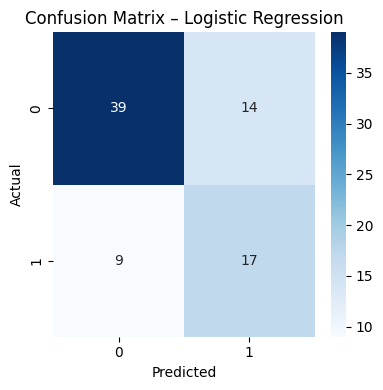

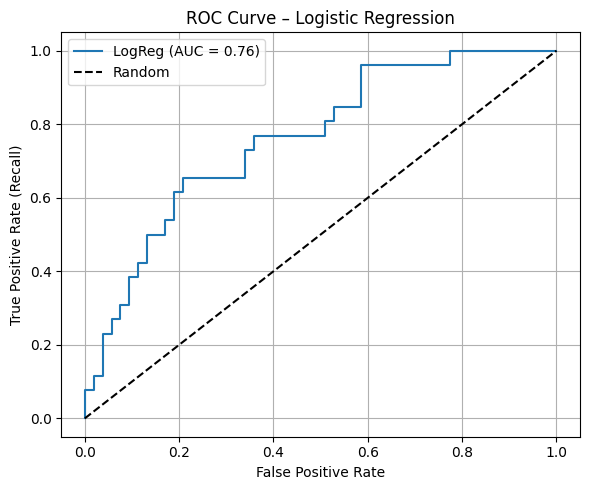

In [76]:
# === Cell 6: Metrics for Logistic Regression ===

# Predictions and probabilities
y_val_pred_lr = log_reg_pipeline.predict(X_val)
y_val_proba_lr = log_reg_pipeline.predict_proba(X_val)[:, 1]

# Scalar metrics
acc_lr = accuracy_score(y_val, y_val_pred_lr)
prec_lr = precision_score(y_val, y_val_pred_lr)
rec_lr = recall_score(y_val, y_val_pred_lr)
f1_lr = f1_score(y_val, y_val_pred_lr)
roc_auc_lr = roc_auc_score(y_val, y_val_proba_lr)

print("Logistic Regression – Validation metrics")
print(f"Accuracy : {acc_lr:.3f}")
print(f"Precision: {prec_lr:.3f}")
print(f"Recall   : {rec_lr:.3f}")
print(f"F1-score : {f1_lr:.3f}")
print(f"ROC-AUC  : {roc_auc_lr:.3f}\n")

print("Classification report (LogReg):")
print(classification_report(y_val, y_val_pred_lr))

# Confusion matrix
cm_lr = confusion_matrix(y_val, y_val_pred_lr)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()

# ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_proba_lr)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
import os, joblib

save_path = "../models/student_risk_pipeline.joblib"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

joblib.dump(log_reg_pipeline, save_path)
print("Saved to:", os.path.abspath(save_path))


Saved to: c:\Users\BUNNY\Projects\student-risk-prediction-system\models\student_risk_pipeline.joblib


Decision Tree – Validation metrics
Accuracy : 0.582
Precision: 0.394
Recall   : 0.500
F1-score : 0.441
ROC-AUC  : 0.561

Classification report (Decision Tree):
              precision    recall  f1-score   support

           0       0.72      0.62      0.67        53
           1       0.39      0.50      0.44        26

    accuracy                           0.58        79
   macro avg       0.56      0.56      0.55        79
weighted avg       0.61      0.58      0.59        79



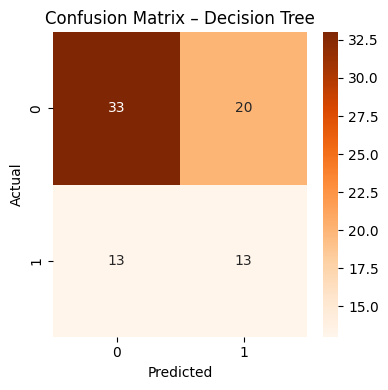

In [77]:
# === Cell 7: Decision Tree model and metrics ===

dt_clf = DecisionTreeClassifier(
    max_depth=None,      # you can later tune: e.g., 3, 4, 5
    random_state=42
)

dt_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", dt_clf)
    ]
)

dt_pipeline.fit(X_train, y_train)

y_val_pred_dt = dt_pipeline.predict(X_val)
y_val_proba_dt = dt_pipeline.predict_proba(X_val)[:, 1]

acc_dt = accuracy_score(y_val, y_val_pred_dt)
prec_dt = precision_score(y_val, y_val_pred_dt)
rec_dt = recall_score(y_val, y_val_pred_dt)
f1_dt = f1_score(y_val, y_val_pred_dt)
roc_auc_dt = roc_auc_score(y_val, y_val_proba_dt)

print("Decision Tree – Validation metrics")
print(f"Accuracy : {acc_dt:.3f}")
print(f"Precision: {prec_dt:.3f}")
print(f"Recall   : {rec_dt:.3f}")
print(f"F1-score : {f1_dt:.3f}")
print(f"ROC-AUC  : {roc_auc_dt:.3f}\n")

print("Classification report (Decision Tree):")
print(classification_report(y_val, y_val_pred_dt))

cm_dt = confusion_matrix(y_val, y_val_pred_dt)
plt.figure(figsize=(4, 4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Decision Tree")
plt.tight_layout()
plt.show()


In [78]:
# === Cell 8: Compare Logistic Regression vs Decision Tree ===

comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree"],
    "Accuracy": [acc_lr, acc_dt],
    "Precision (fail)": [prec_lr, prec_dt],
    "Recall (fail)": [rec_lr, rec_dt],
    "F1 (fail)": [f1_lr, f1_dt],
    "ROC-AUC": [roc_auc_lr, roc_auc_dt]
})

comparison


,Model,Accuracy,Precision (fail),Recall (fail),F1 (fail),ROC-AUC
0,Logistic Regression,0.708861,0.548387,0.653846,0.596491,0.761974
1,Decision Tree,0.582278,0.393939,0.500000,0.440678,0.561321


In [ ]:
# === Cell 9: Regularization experiments – L2 with different C and L1 ===

def eval_log_reg_model(penalty="l2", C_value=1.0, class_weight="balanced"):
    model = LogisticRegression(
        penalty=penalty,
        solver="liblinear",
        max_iter=1000,
        C=C_value,
        class_weight=class_weight
    )
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ]
    )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    return {
        "penalty": penalty,
        "C": C_value,
        "acc": accuracy_score(y_val, y_pred),
        "prec": precision_score(y_val, y_pred),
        "rec": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "roc_auc": roc_auc_score(y_val, y_proba)
    }

results = []

# L2 with different C
for C_val in [0.1, 1.0, 10.0]:
    results.append(eval_log_reg_model(penalty="l2", C_value=C_val))

# L1 with C=1.0
results.append(eval_log_reg_model(penalty="l1", C_value=1.0))

reg_results = pd.DataFrame(results)
reg_results


In [ ]:
# === Cell 10: Logistic Regression coefficients (feature importance) ===

# Fit preprocessor alone to get feature names
preprocessor.fit(X_train)

num_feats = numeric_features
cat_ohe = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = np.concatenate([num_feats, cat_ohe])

log_reg_model = log_reg_pipeline.named_steps["model"]
coefs = log_reg_model.coef_[0]

feature_importance = (
    pd.DataFrame({"feature": all_features, "coef": coefs})
    .sort_values(by="coef", ascending=False)
)

print("Top positive coefficients (risk-increasing):")
display(feature_importance.head(10))

print("Top negative coefficients (risk-reducing):")
display(feature_importance.tail(10))


In [ ]:
# === Save trained pipeline ===
import joblib  # usually installed with scikit-learn

joblib.dump(log_reg_pipeline, "../models/student_risk_pipeline.joblib")
print("Model pipeline saved.")
